In [1]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_le

In [2]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [19]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

In [20]:
characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

In [21]:
path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [22]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [23]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor()
])

In [24]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

In [25]:
train_loader = DataLoader(train_generator, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_generator, batch_size=128, shuffle=False)

In [26]:
# Defineix el model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

Epoch 1/20, Train Loss: 2.7644, Train Acc: 0.2208, Test Loss: 2.4065, Test Acc: 0.3726
Epoch 2/20, Train Loss: 1.8668, Train Acc: 0.5225, Test Loss: 1.5134, Test Acc: 0.5976
Epoch 3/20, Train Loss: 1.3211, Train Acc: 0.6454, Test Loss: 1.2018, Test Acc: 0.6706
Epoch 4/20, Train Loss: 1.0993, Train Acc: 0.7024, Test Loss: 1.0427, Test Acc: 0.7185
Epoch 5/20, Train Loss: 0.9791, Train Acc: 0.7348, Test Loss: 0.9547, Test Acc: 0.7366
Epoch 6/20, Train Loss: 0.9023, Train Acc: 0.7569, Test Loss: 0.8864, Test Acc: 0.7550
Epoch 7/20, Train Loss: 0.8465, Train Acc: 0.7741, Test Loss: 0.8374, Test Acc: 0.7774
Epoch 8/20, Train Loss: 0.8023, Train Acc: 0.7874, Test Loss: 0.7947, Test Acc: 0.7917
Epoch 9/20, Train Loss: 0.7648, Train Acc: 0.7991, Test Loss: 0.7676, Test Acc: 0.7950
Epoch 10/20, Train Loss: 0.7338, Train Acc: 0.8087, Test Loss: 0.7385, Test Acc: 0.8073
Epoch 11/20, Train Loss: 0.7065, Train Acc: 0.8163, Test Loss: 0.7056, Test Acc: 0.8163
Epoch 12/20, Train Loss: 0.6828, Train Ac

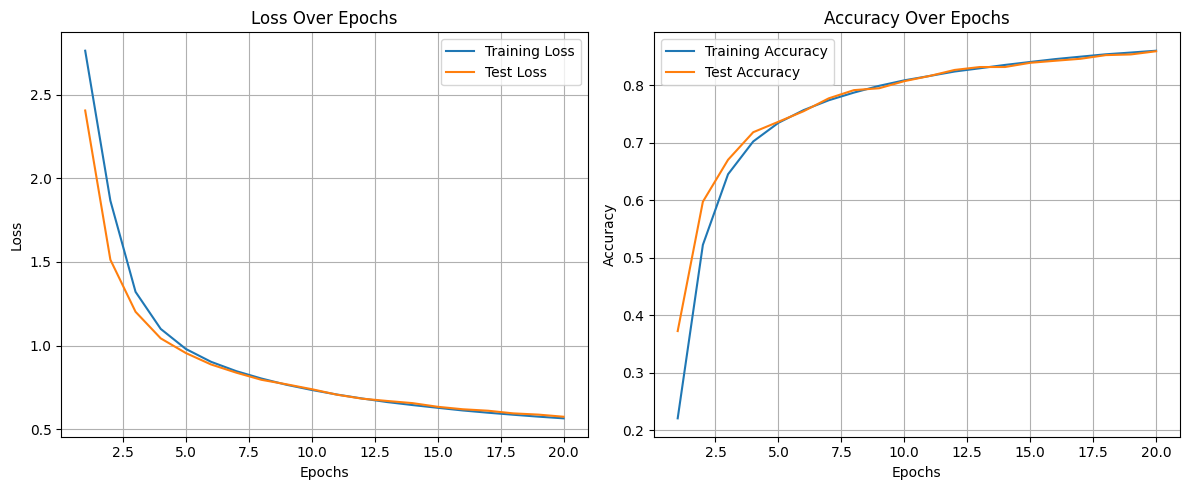

In [28]:
# Entrenar el modelo
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(validation_loader)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

# Guardar el modelo entrenado
# Guardar el modelo y el optimizador
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'simple_cnn_model.pth')

# Crear la gráfica de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Crear una nueva instancia del modelo
model1 = SimpleCNN()

# Cargar el estado del modelo
model1.load_state_dict(torch.load('simple_cnn_model.pth'))

# Poner el modelo en modo evaluación
model1.eval()


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=560, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=29, bias=True)
)

In [42]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []
incorrect_indices = []
index_offset = 0  # Para mantener el índice global


with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(validation_generator):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels_batch = labels.cpu().numpy()
        predicted_labels_batch = predicted.cpu().numpy()
        true_labels.extend(true_labels_batch)
        predicted_labels.extend(predicted_labels_batch)

        for idx_in_batch, (true, pred) in enumerate(zip(true_labels_batch, predicted_labels_batch)):
            if true != pred:
                incorrect_indices.append(index_offset + idx_in_batch)

        index_offset += len(labels)  # Incrementar el índice global


same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

Nombre de lletres correctes: 16813
Percentatge de lletres correctes: 85.92967392415414%


In [58]:
def generate_unique_sorted_numbers(exclude_list, size=8):
    """
    Genera una lista ordenada de números únicos que no están en la lista de exclusión,
    empezando desde 0.

    :param exclude_list: Lista de números a excluir.
    :param size: Tamaño de la lista a generar.
    :return: Lista ordenada de números únicos.
    """
    exclude_set = set(exclude_list)
    unique_numbers = [num for num in range(size + len(exclude_list) + 1) if num not in exclude_set]
    return unique_numbers[:size]


exclude_list = incorrect_indices
correct_indices = generate_unique_sorted_numbers(exclude_list)
incorrect_indices = incorrect_indices[:8]  # Seleccionar los primeros 8 índices incorrectos


**Imprimir 8 imatges que prediu bé**




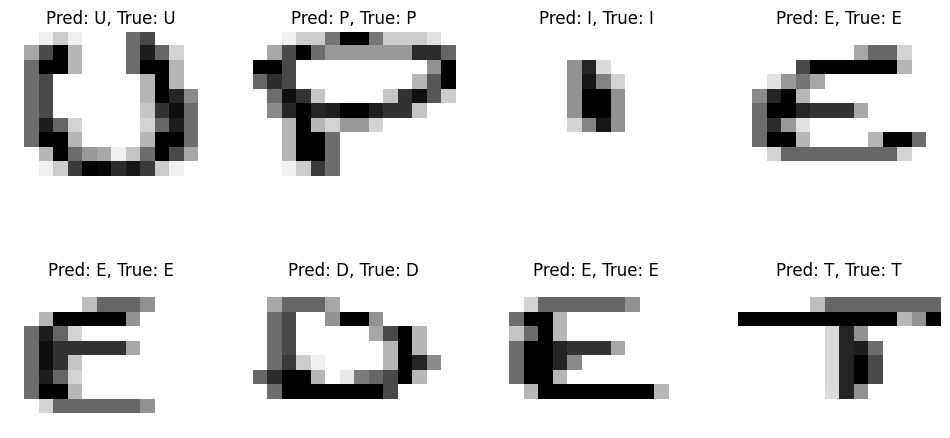

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for ax, idx in zip(axes.flatten(), correct_indices):
    img, _ = validation_generator[idx]
    img = img.squeeze().cpu().numpy()  # Convertir el tensor de imagen a numpy array
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    pre = predicted_labels[idx]
    tru = true_labels[idx]
    ax.set_title(f'Pred: {characters[pre]}, True: {characters[tru]}')

plt.show()


**Imprimir 8 imatges que prediu malament**

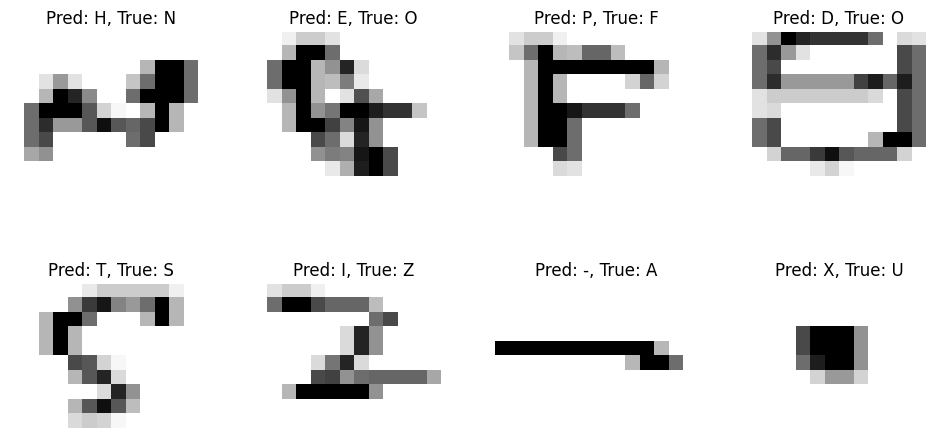

In [57]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, idx in zip(axes.flatten(), incorrect_indices):
    img, _ = validation_generator[idx]
    img = img.squeeze().cpu().numpy()  # Convertir el tensor de imagen a numpy array
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    pre = predicted_labels[idx]
    tru = true_labels[idx]
    ax.set_title(f'Pred: {characters[pre]}, True: {characters[tru]}')

plt.show()

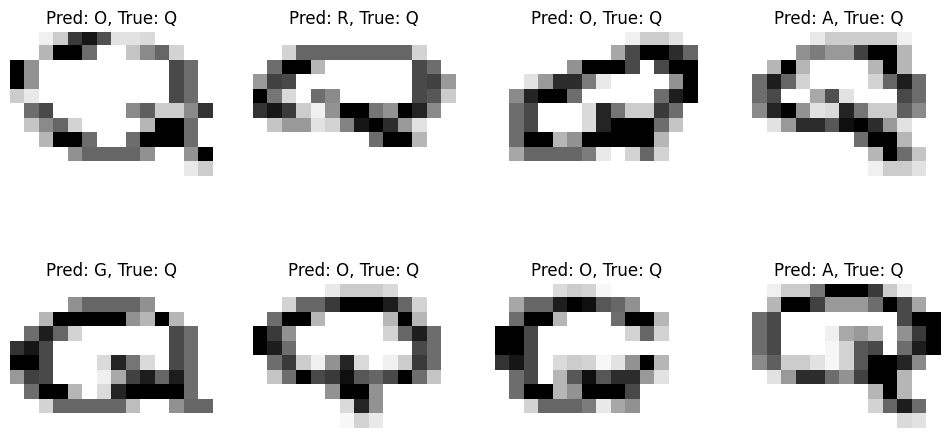

In [75]:
lletra = "Q"
num = characters.index(lletra)
new_indices = [indice for indice, numero in enumerate(true_labels) if numero == num]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, idx in zip(axes.flatten(), new_indices):
    img, _ = validation_generator[idx]
    img = img.squeeze().cpu().numpy()  # Convertir el tensor de imagen a numpy array
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    pre = predicted_labels[idx]
    tru = true_labels[idx]
    ax.set_title(f'Pred: {characters[pre]}, True: {characters[tru]}')
plt.show()

23
23


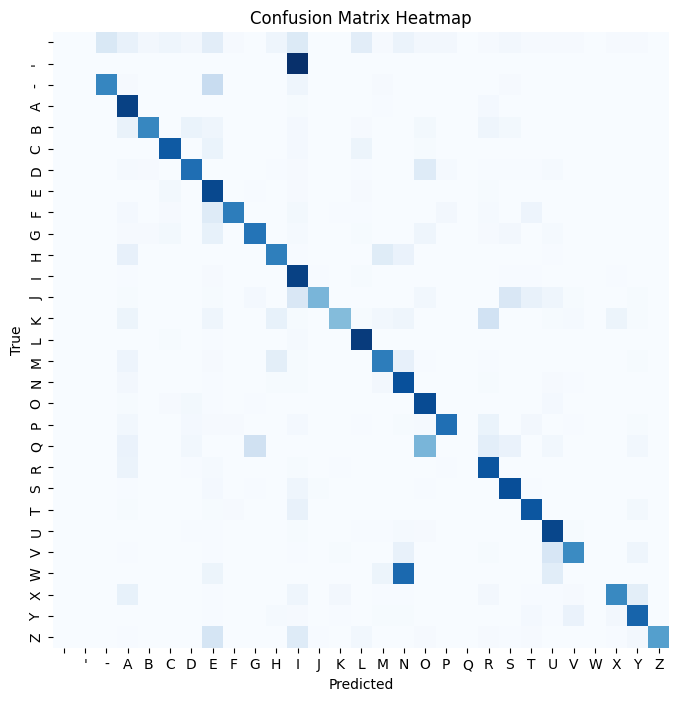

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming true_labels and predicted_labels are defined as shown previously
conf_mat = confusion_matrix(true_labels, predicted_labels,normalize='true')

# Plotting the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=False, cmap='Blues', cbar=False, square=True, xticklabels=characters, yticklabels=characters)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()